In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from pathlib import Path
import torchaudio
import fairseq
import torch
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
def get_mos_data(split):
    mos_list_file = f'../data/phase1-main/DATA/sets/{split}_mos_list.txt'
    mos_data = {}
    for line in open(mos_list_file):
        file_id, mos = line.rstrip().split(',')
        mos = float(mos)
        mos_data[file_id] = mos
    return mos_data

In [4]:
train_mos_data = get_mos_data('train')
len(train_mos_data)

4974

In [5]:
val_mos_data = get_mos_data('val')
len(val_mos_data)

1066

In [6]:
wav_dir = Path('../data/phase1-main/DATA/wav/')

wavpath = wav_dir / 'sys64e2f-utt9c183cd.wav'
wav = torchaudio.load(wavpath)[0]
wav.size()

torch.Size([1, 42944])

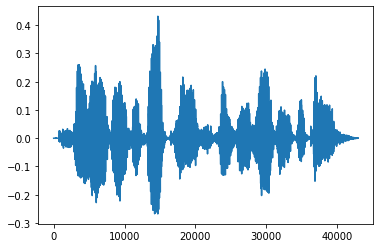

In [7]:
plt.plot(wav.numpy().ravel())

In [8]:
fairseq_base_model = '../fairseq/w2v_large_lv_fsh_swbd_cv.pt'
# fairseq_base_model = '../fairseq/xlsr_53_56k.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([fairseq_base_model])
# model

In [9]:
ssl_model = model[0]

In [10]:
ssl_model.remove_pretraining_modules()
ssl_model.to(device)
ssl_model.eval();

In [11]:
output_wavs = torch.stack([wav], dim=0)
output_wavs.size()

torch.Size([1, 1, 42944])

In [12]:
res = ssl_model(wav.to(device), mask=False, features_only=True)
res

{'x': tensor([[[-1.0673e-05, -9.9960e-06, -6.6190e-06,  ...,  2.9371e-05,
            1.0921e-06, -7.4574e-06],
          [-1.2682e-05, -1.0027e-05, -6.8847e-06,  ...,  3.0761e-05,
            1.0802e-06, -7.5651e-06],
          [-1.2605e-05, -1.0042e-05, -6.8116e-06,  ...,  2.9807e-05,
            1.0732e-06, -7.7207e-06],
          ...,
          [-1.3767e-05, -1.0061e-05, -7.0104e-06,  ...,  3.0785e-05,
            1.0569e-06, -7.7199e-06],
          [-1.3723e-05, -1.0093e-05, -6.9899e-06,  ...,  3.0724e-05,
            1.0543e-06, -7.7435e-06],
          [-1.3392e-05, -1.0158e-05, -6.9703e-06,  ...,  3.0705e-05,
            1.0560e-06, -7.6905e-06]]], device='cuda:0',
        grad_fn=<NativeLayerNormBackward0>),
 'padding_mask': None,
 'features': tensor([[[-0.8240, -0.6323,  0.6797,  ...,  0.7917, -0.7093, -0.3612],
          [-0.8099, -0.6152,  0.6319,  ...,  0.7159, -0.7150, -0.4230],
          [-0.7886, -0.5795, -0.6736,  ...,  0.1342, -0.8482, -0.3338],
          ...,
        

In [13]:
res['x'].size()

torch.Size([1, 133, 1024])

In [14]:
res['features'].size()

torch.Size([1, 133, 512])

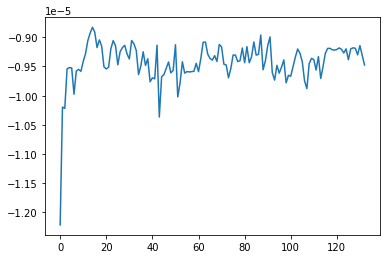

In [15]:
plt.plot(res['x'].squeeze(0)[:, 350].detach().cpu().numpy())

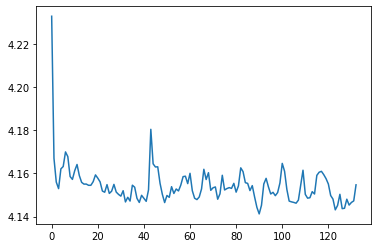

In [16]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=1).detach().cpu().numpy())

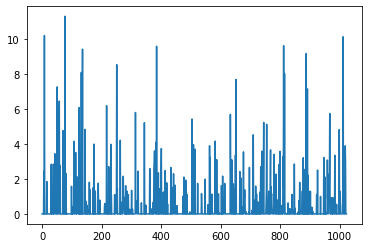

In [17]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=0).detach().cpu().numpy())

In [18]:
def extract_mean(wavpath):
    with torch.no_grad():
        wav = torchaudio.load(wavpath)[0]
        res = ssl_model(wav.to(device), mask=False, features_only=True)
        return res['x'].squeeze(0).mean(dim=0)


In [19]:
extract_mean(wavpath).size()

torch.Size([1024])

In [20]:
out_dir = Path('../out/utt_data/w2v_large2')
import os
os.makedirs(out_dir, exist_ok=True)


In [21]:
val_vecs = []
val_moss = []

for key, mos in tqdm(sorted(val_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    val_vecs.append(vec)
    val_moss.append(mos)

  0%|          | 0/1066 [00:00<?, ?it/s]

In [22]:
train_vecs = []
train_moss = []

for key, mos in tqdm(sorted(train_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    train_vecs.append(vec)
    train_moss.append(mos)

  0%|          | 0/4974 [00:00<?, ?it/s]

In [23]:
# train_X = np.array(train_vecs)
# train_y = np.array(train_moss)
# val_X = np.array(val_vecs)
# val_y = np.array(val_moss)
# train_X.shape

In [24]:
# uttemb_dir = Path('../out/utt_emb/w2v_large')
# os.makedirs(uttemb_dir)
# np.save(uttemb_dir / 'train_X.npy', train_X)
# np.save(uttemb_dir / 'train_y.npy', train_y)
# np.save(uttemb_dir / 'val_X.npy', val_X)
# np.save(uttemb_dir / 'val_y.npy', val_y)